In [ ]:
import tensorflow as tf
import keras
from tensorflow import keras
import kagglehub


from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

import os
import cv2
import numpy as np
from imgaug import augmenters as iaa

from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

2024-12-03 14:25:14.197568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
train_images = os.path.join(path, 'asl_alphabet_train', 'asl_alphabet_train')

# Augmentation Sequence
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontally flip 50% of images
    iaa.Affine(rotate=(-10, 10)),  # Rotate images within [-10, 10] degrees
    iaa.AddToBrightness((-30, 30)),  # Adjust brightness
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Add Gaussian noise
    iaa.Crop(percent=(0, 0.1))  # Crop by up to 10% from each side
])

# Data loading and augmentation
def get_data_with_augmentation(data_dir):
    images = []
    labels = []

    dir_list = os.listdir(data_dir)
    for i, label in enumerate(dir_list):
        print("Obtaining and augmenting images of", label, "...")
        for image in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, image)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (32, 32))
            
            # Append the original image
            images.append(img)
            labels.append(i)

            # Apply augmentations
            img_augmented = augmentation(images=[img] * 5)  # Augment each image 5 times
            images.extend(img_augmented)
            labels.extend([i] * len(img_augmented))

    return np.array(images), np.array(labels)

# Load data with augmentations
X, y = get_data_with_augmentation(train_images)

print("Dataset Size (including originals and augmentations):", len(X))


Obtaining and augmenting images of R ...
Obtaining and augmenting images of U ...
Obtaining and augmenting images of I ...
Obtaining and augmenting images of N ...
Obtaining and augmenting images of G ...
Obtaining and augmenting images of Z ...
Obtaining and augmenting images of T ...
Obtaining and augmenting images of S ...
Obtaining and augmenting images of A ...
Obtaining and augmenting images of F ...
Obtaining and augmenting images of O ...
Obtaining and augmenting images of H ...
Obtaining and augmenting images of del ...
Obtaining and augmenting images of nothing ...
Obtaining and augmenting images of space ...
Obtaining and augmenting images of M ...
Obtaining and augmenting images of J ...
Obtaining and augmenting images of C ...
Obtaining and augmenting images of D ...
Obtaining and augmenting images of V ...
Obtaining and augmenting images of Q ...
Obtaining and augmenting images of X ...
Obtaining and augmenting images of E ...
Obtaining and augmenting images of B ...
Obta

In [ ]:
# Split into Training and Test
import sklearn
from sklearn.model_selection import train_test_split

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

X = np.array(X)
y = np.array(y)

# Normalize the images (scale pixel values to range [0, 1])
X_normalized = X.astype('float32') / 255.0

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Verify the shapes
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")


y_train_encoded = to_categorical(y_train, num_classes=len(labels))
y_test_encoded = to_categorical(y_test, num_classes=len(labels))


Training data shape: (417600, 32, 32, 3), Test data shape: (104400, 32, 32, 3)
Training labels shape: (417600,), Test labels shape: (104400,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [75]:
classes = 29
batch = 128
epochs = 15
learning_rate = 0.01

model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#model.add(Conv2D(256, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(classes, activation='softmax'))

adam = Adam(learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=2,              
    restore_best_weights=True 
)

history = model.fit(X_train, y_train_encoded, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1,
    callbacks=[early_stopping])

Epoch 1/15
2610/2610 [==============================] - 558s 213ms/step - loss: 2.2090 - accuracy: 0.3796 - val_loss: 0.9770 - val_accuracy: 0.6869
Epoch 2/15
2610/2610 [==============================] - 546s 209ms/step - loss: 0.5748 - accuracy: 0.8136 - val_loss: 0.6828 - val_accuracy: 0.7926
Epoch 3/15
2610/2610 [==============================] - 516s 198ms/step - loss: 0.4756 - accuracy: 0.8600 - val_loss: 0.7035 - val_accuracy: 0.8327
Epoch 4/15
2610/2610 [==============================] - 513s 197ms/step - loss: 0.4549 - accuracy: 0.8754 - val_loss: 0.3255 - val_accuracy: 0.8988
Epoch 5/15
2610/2610 [==============================] - 518s 198ms/step - loss: 0.4358 - accuracy: 0.8859 - val_loss: 1.2857 - val_accuracy: 0.7964
Epoch 6/15
2610/2610 [==============================] - 519s 199ms/step - loss: 0.4437 - accuracy: 0.8916 - val_loss: 0.6868 - val_accuracy: 0.8489


In [76]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


3263/3263 [==============================] - 79s 24ms/step - loss: 0.3284 - accuracy: 0.8998
Test Loss: 0.3284, Test Accuracy: 0.8998


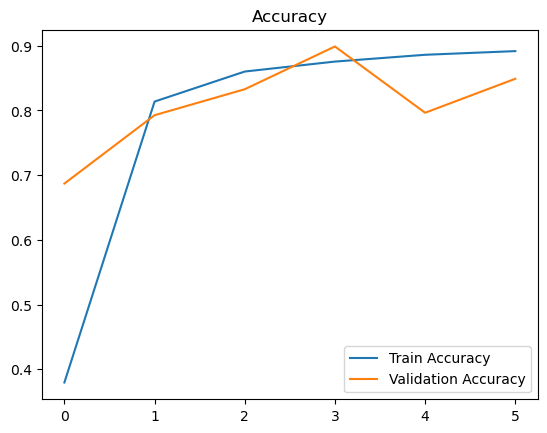

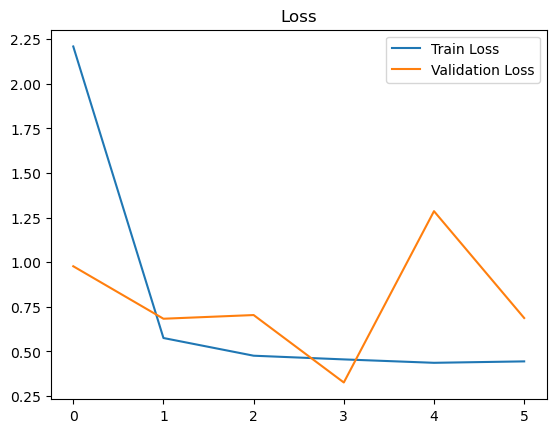

In [77]:
# Training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Classification report
print(classification_report(y_test_classes, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)


3263/3263 [==============================] - 109s 33ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3575
           1       0.89      0.91      0.90      3570
           2       0.98      0.94      0.96      3645
           3       0.89      0.94      0.92      3543
           4       0.93      0.95      0.94      3672
           5       0.97      0.98      0.98      3605
           6       0.95      0.98      0.97      3574
           7       0.91      0.92      0.92      3520
           8       0.95      0.95      0.95      3529
           9       0.99      0.98      0.98      3676
          10       0.98      0.97      0.98      3628
          11       0.93      0.98      0.95      3702
          12       0.99      0.88      0.93      3504
          13       0.99      1.00      0.99      3706
          14       0.99      0.98      0.98      3518
          15       0.92      0.88      0.90      3492
          16       0.